# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
# import cProfile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [2]:
nop.plot_setup()
cmap = "inferno"

In [20]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    # G=nx.empty_graph(1),
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=0,
        scale=10,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=1,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=100,  # End time of simulation
    t_sample=1,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    sampling=True,
)

In [21]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [22]:
# cProfile.run("nop.run_ConjMu(**input)")

In [23]:
out1 = nop.run_ConjMu(**input)

print(out1["N_events"])

19917


In [24]:
nop.export_hdf5(out1, "test.h5")

In [25]:
out1 = nop.import_hdf5("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [26]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
# plt.rcParams.update(
#    {
#        "font.size": 20,
#        "legend.loc": "upper right",
#    }
# )

#### Data analysis 1

Firstly, extract output values for further analysis:

In [27]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConj
mu_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 1.,  7.,  7.,  9., 12.,  9., 10.,  8.,  8.,  8.,  5.,  4.,  2.,
         2.,  1.,  1.,  1.,  3.,  0.,  2.]),
 array([0.04256244, 0.04501762, 0.0474728 , 0.04992797, 0.05238315,
        0.05483833, 0.05729351, 0.05974869, 0.06220386, 0.06465904,
        0.06711422, 0.0695694 , 0.07202458, 0.07447975, 0.07693493,
        0.07939011, 0.08184529, 0.08430046, 0.08675564, 0.08921082,
        0.091666  ]),
 <BarContainer object of 20 artists>)

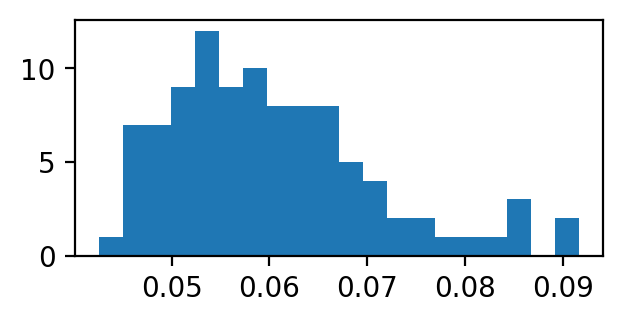

In [28]:
sigmas = []
for i in out1["nodesConj"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots()
ax.hist(sigmas, bins=20)

[[ 7.59305233e-01 -1.00000000e+00  5.33364708e-01]
 [ 9.16883704e+00  2.60000000e+01  9.71846366e-01]
 [ 1.15467081e+00  2.30000000e+01  1.95723177e+00]
 [ 1.28594987e-01  7.00000000e+01  2.37656446e+00]
 [ 2.27528556e-01 -1.00000000e+00  2.45904071e+00]
 [-6.57204922e-01 -1.00000000e+00  2.48148704e+00]
 [ 1.68330273e+00  7.00000000e+01  3.71033996e+00]
 [ 4.08219549e-01  3.60000000e+01  4.07296103e+00]
 [ 2.77857128e+00  7.00000000e+01  4.13336087e+00]
 [ 1.16364766e+00  7.00000000e+01  4.25770398e+00]
 [-1.03030258e+00 -1.00000000e+00  5.50228265e+00]
 [-1.80604711e+00  2.30000000e+01  5.67852878e+00]
 [-1.73299961e+00 -1.00000000e+00  5.79728048e+00]
 [ 1.05158526e-01  2.30000000e+01  5.81007626e+00]
 [ 6.82595014e-01 -1.00000000e+00  6.30820787e+00]
 [-2.13399031e+00  2.60000000e+01  6.40315693e+00]
 [ 1.81117917e+00  7.00000000e+01  6.47314849e+00]
 [ 4.72786766e-01  2.60000000e+01  7.22901043e+00]
 [-4.16616921e-01  2.30000000e+01  7.25625554e+00]
 [-5.82982311e-01 -1.00000000e+

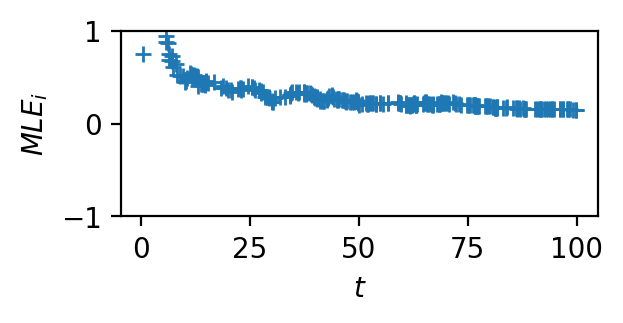

In [29]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConj"][k]
# mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots()
# ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
# )

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.set_ylim(-1, 1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
# fig.savefig("graphics-output/mu_N1.png", dpi=1500)

(101, 100)
101


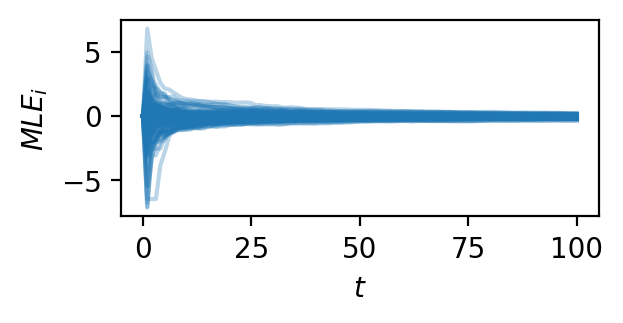

In [35]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
print(len(x))
fig, ax = plt.subplots()
for i, mu in enumerate(mu_arr.T):
    ax.plot(x, mu, alpha=0.3, label=f"$\mu_{i}$", color="tab:blue")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
# ax.set_ylim(-100, 100)
# ax.set_yscale("log")
# ax.loglog()
# ax.legend()
fig.savefig("./graphics-output/mu_nodes.png", dpi=1500)

#### Data analysis 2

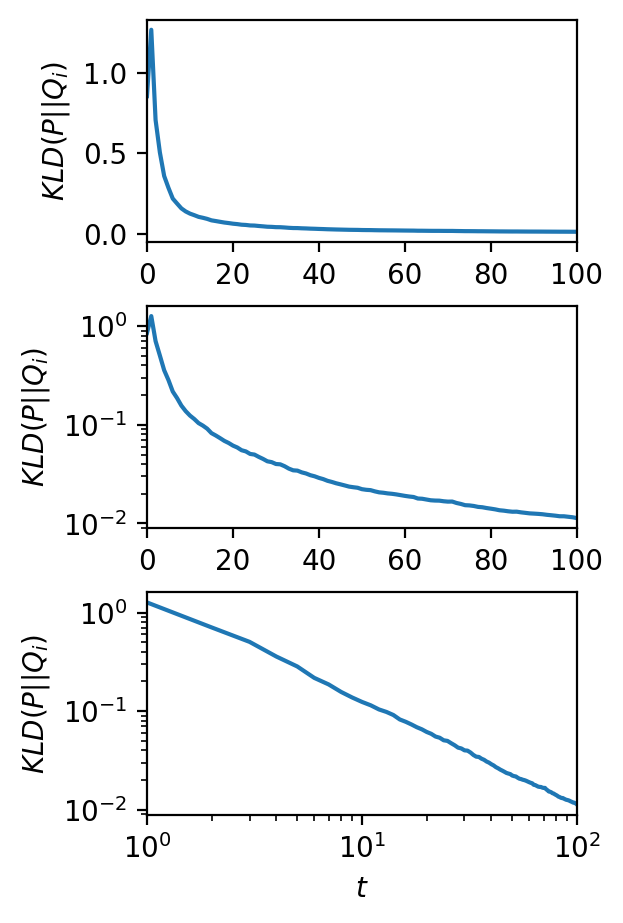

In [36]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(3, 4.5))
x = input["t_sample"] * np.arange(0, kld.shape[0])
for i, _ in enumerate(ax):
    ax[i].plot(
        x,  # input["t_sample"] * np.arange(0, kld.shape[0]),
        kld.mean(axis=1),
        label="$KLD_i$",
    )
    ax[i].set_ylabel("$KLD(P||Q_i)$")
    ax[i].set_xlim(0, x[-1])
ax[2].set_xlabel("$t$")
ax[1].set_yscale("log")
ax[2].loglog()
ax[2].set_xlim(input["t_sample"], input["t_max"])
fig.savefig("./graphics-output/KLD.png", dpi=1500)

(101, 100)


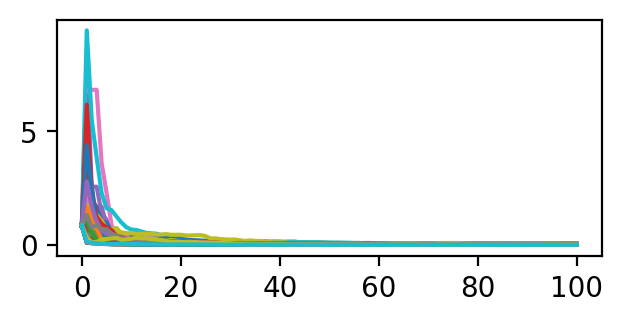

In [34]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
print(kld.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i, _ in enumerate(kld.T):
    ax.plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld[:, i],
        label="avg",
    )
# plt.loglog()
# plt.ylim(0, 2)